In [36]:
import math
import itertools
import multiprocessing as mp

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import polarization as plr
import cli_utils as cli

plt.rcParams.update({'font.size': 16, 'xtick.labelsize': 'small', 'ytick.labelsize': 'x-small', 'legend.fontsize': 'x-small'})

# Run Simulations

By default the `Simulation`' `run` method returns the polarization evolution
at each time step up to `max_time` (100 by default) time steps, each agents' belief
evolution, and the polarization value at the end of the simulation.

Also by default, the `Simulation` class uses the classic, or rational, update function,
and a Esteban-Ray polarization measure with the above default values. The `smart_stop`
argument, `True` by default, stops the simulation if the belief vector does not change
from one time step to the next.

## Definitions for Initial Beliefs' Configuration

Here is a new enumeration and function that allows us to generate new initial belief configurations based on the 5 bins Polarization measure.


| Name        | [0, 0.2) | [0.2, 0.4) | [0.4, 0.6) | [0.6, 0.8) | [0.8, 1) |
| ----------- | :------: | :--------: | :--------: | :--------: | :------: |
| Uniform     | o | o | o | o | o |
| Mild        |   | o |   | o |   |
| Extreme     | o |   |   |   | o |
| Tri-partite | o |   | o |   | o |


## Other Parameters

The default parameters are defined as constants in the `polarization.py` module.

- NUM_AGENTS = 100


- NUM_BINS = 5
- ALPHA = 1.6
- K = 1000


- CLIQUE_INF_VALUE = 0.5


- GROUPS_DISCONNECTED_INF_VALUE = 0.5


- GROUPS_FAINTLY_INF_VALUE_STRONG = 0.5
- GROUPS_FAINTLY_INF_VALUE_WEAK = 0.1


- INFLUENCERS_BALANCED_OUTGOING_BOTH = 0.6
- INFLUENCERS_BALANCED_INCOMING_BOTH = 0.0
- INFLUENCERS_BALANCED_OTHERS = 0.1


- INFLUENCERS_UNBALANCED_OUTGOING_FIRST = 0.8
- INFLUENCERS_UNBALANCED_OUTGOING_SECOND = 0.1
- INFLUENCERS_UNBALANCED_INCOMING_FIRST = 0.1
- INFLUENCERS_UNBALANCED_INCOMING_SECOND = 0.1
- INFLUENCERS_UNBALANCED_OTHERS = 0.1


- CIRCULAR_INF_VALUE = 0.5


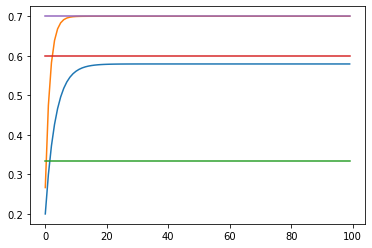

In [3]:
import random
num_agents = 5

# Lets created a random influence graph.
# We could also use the plr.build_influence(inf_type) function to create the influence graph
# from a preset scenario, see the plr.Influence enum.
inf = np.array([[random.random() if random.random() > 0.9 else 0.0 for _ in range(num_agents)] for _ in range(num_agents)])
np.fill_diagonal(inf, 1.0)

pol_history, belief_history, _ = plr.Simulation(
    plr.build_belief(plr.Belief.MILD, num_agents),
    inf # Classic Update by default
).run()

plt.plot(belief_history)
plt.show()

# Plotting Simulations for Presentation

The following code generates, and can save, all the figures ready to be displayed in presentations.

In [8]:
def get_hr_name(inf_blf_fn):
    """Returns a human readable version of a Belief, an Influence, or an Update function.
    """
    if inf_blf_fn is plr.Influence.CLIQUE:
        return "clique"
    if inf_blf_fn is plr.Influence.GROUP_2_DISCONECTED:
        return "disconnected"
    if inf_blf_fn is plr.Influence.GROUP_2_FAINT:
        return "faintly-communicating"
    if inf_blf_fn is plr.Influence.INFLUENCERS_2_BALANCED:
        return "unrelenting influencers"
    if inf_blf_fn is plr.Influence.INFLUENCERS_2_UNBALANCED:
        return "malleable influencers"
    if inf_blf_fn is plr.Influence.CIRCULAR:
        return "circular"
    if inf_blf_fn is plr.Belief.UNIFORM:
        return "uniform"
    if inf_blf_fn is plr.Belief.MILD:
        return "mildly polarized"
    if inf_blf_fn is plr.Belief.EXTREME:
        return "extremely polarized"
    if inf_blf_fn is plr.Belief.TRIPLE:
        return "tripolar"
    if inf_blf_fn is plr.Belief.CONSENSUS:
        return "consensus"
    if inf_blf_fn is plr.Update.CLASSIC:
        return "classic update"
    if inf_blf_fn is plr.Update.CONFBIAS:
        return "confirmation bias"
    else:
        return "undefined"

def get_color_subgroups(data, num_agents):
    if data is plr.Belief.EXTREME or data is plr.Belief.MILD or data is plr.Influence.GROUP_2_DISCONECTED or data is plr.Influence.GROUP_2_FAINT:
        middle = math.ceil(num_agents / 2)
        return [middle, num_agents - middle]
    if data is plr.Belief.TRIPLE:
        last_third = num_agents // 3 # floor
        middle_third = math.ceil(num_agents / 3)
        first_third = num_agents - middle_third - last_third
        return [first_third, middle_third, last_third]
    if data is plr.Influence.INFLUENCERS_2_BALANCED or data is plr.Influence.INFLUENCERS_2_UNBALANCED:
        return [1, num_agents - 2, 1]
    # For all other blfs: CONSENSUS, UNIFORM; infs: CLIQUE, CIRCULAR
    return [num_agents]

def get_colors(data, num_agents=None):
    """Returns the color maps for a given blf.

    If `data` is a Belief, then generates the appropiate colormaps.
    If `data` is a list of numbers, then uses the number of colormaps requested.
    """
    subgroups = []
    if isinstance(data, (plr.Belief, plr.Influence)):
        if num_agents is None:
            num_agents = plr.NUM_AGENTS
        subgroups = get_color_subgroups(data, num_agents)
    else:
        subgroups = data
    maps = ['winter', 'autumn', 'summer', 'cool', 'Wistia']
    # cmap = plt.get_cmap("viridis")
    colors = []
    for subgroup, cmap in zip(subgroups, itertools.cycle(maps)):
        cmap_fn = plt.get_cmap(cmap)
        for j in range(subgroup):
            colors.append(cmap_fn(j/(subgroup*1.5)))
    return colors

def plot_only_polarization(sims, blf_name=None, inf_name=None, fn_name=None, file_name=None, limit_x=False, name_prefix="", save_file=False):
    """Generates a plot comparing polarization data, optionally saves it to disk.

    If `save_file` is `False` (default), you may want to call `matplotlib.pyplot.show()`
    """
    # Get the variable parameter, either inf, blf or fn.
    var_name = None
    # Set optional parameters
    if blf_name is None:
        if "blf" in sims:
            blf_name = get_hr_name(sims["blf"])
        else:
            var_name = 'blf'
    if inf_name is None:
        if "inf" in sims:
            inf_name = get_hr_name(sims["inf"])
        else:
            var_name = 'inf'
    if fn_name is None:
        if "fn" in sims:
            fn_name = get_hr_name(sims["fn"])
        else:
            var_name = 'fn'
    if file_name is None:
        try:
            iname = sims["inf"].name
        except (AttributeError, KeyError):
            if inf_name is not None:
                iname = inf_name
            else:
                iname = "X"
        try:
            bname = sims["blf"].name
        except (AttributeError, KeyError):
            if blf_name is not None:
                bname = blf_name
            else:
                bname = "X"
        try:
            fname = sims["fn"].name
        except (AttributeError, KeyError):
            if fn_name is not None:
                fname = fn_name
            else:
                fname = "X"
        file_name = "{}{}_{}_{}.png".format(name_prefix, fname, iname, bname)
    plt.figure()
    for sim in sims["sim"]:
        data = sim['sim'][0]
        if limit_x:
            data = data[:100]
        plt.plot(data, label=get_hr_name(sim[var_name]), linestyle="dashed")

    title = ""
    if fn_name:
        title += "Update function: {}".format(fn_name)
        if inf_name or blf_name:
            title += "\n"
    if inf_name:
        title += "Influence graph: {}".format(inf_name)
        if blf_name:
            title += "\n"
    if blf_name:
        title += "Belief configuration: {}".format(blf_name)
    plt.title(title)
    plt.ylabel("Polarization")
    plt.xlabel("Time")
    plt.legend()

    if save_file:
        plt.savefig("generated/pol/{}".format(file_name))
    

def plot_simulation(sim, blf_name=None, inf_name=None, file_name=None, limit_x=False, add_mean=False, color_groups=None, name_prefix="", save_file=False):
    """Generates a plot ready for presentation and, optionally,  saves it to disk.

    If `save_file` is `False` (default), you may want to call `matplotlib.pyplot.show()`
    """
    f = plt.figure()
    gs = gridspec.GridSpec(3, 1, figure=f, hspace=0)
    axt = f.add_subplot(gs[:-1, :])
    axb = f.add_subplot(gs[-1, :], sharex=axt)

    # Set optional parameters
    if blf_name is None:
        blf_name = get_hr_name(sim["blf"])
    if inf_name is None:
        inf_name = get_hr_name(sim["inf"])
    if file_name is None:
        try:
            iname = sim["inf"].name
        except AttributeError:
            iname = inf_name
        try:
            bname = sim["blf"].name
        except AttributeError:
            bname = blf_name
        file_name = "{}{}_{}.png".format(name_prefix, iname, bname)
    if color_groups is None:
        colors = get_colors(sim["blf"], len(sim["sim"][1][0]))
    else:
        colors = get_colors(color_groups, len(sim["sim"][1][0]))

    # Update colors
    axt.set_prop_cycle(color=colors)

    if limit_x:
        axt.plot(sim["sim"][1][:50])
    else:
        axt.plot(sim["sim"][1])
    axt.set_ylabel("Belief")
    
    if add_mean:
        axt.axhline(np.mean(sim["sim"][1][0]), linestyle="dashed")

    if limit_x:
        axb.plot(sim["sim"][0][:50], color="red")
    else:
        axb.plot(sim["sim"][0], color="red")
    axb.set_ylabel("Polarization")
    axb.set_xlabel("Time")

    title = ""
    if inf_name:
        title += "Influence graph: {}".format(inf_name)
        if blf_name:
            title += "\n"
    if blf_name:
        title += "Belief configuration: {}".format(blf_name)
    axt.set_title(title)

    if save_file:
        plt.savefig("generated/{}".format(file_name))

def run_simulations(update_fn, num_agents=plr.NUM_AGENTS, cmax_time=200):
    """Runs all the main simulations."""
    raw_simulations = [{
        "sim": plr.Simulation(plr.build_belief(blf, num_agents), plr.build_influence(inf, num_agents), update_fn),
        "blf": blf,
        "inf": inf,
        "id": 1 } for inf in (plr.Influence.CLIQUE, plr.Influence.GROUP_2_DISCONECTED, plr.Influence.GROUP_2_FAINT, plr.Influence.INFLUENCERS_2_BALANCED, plr.Influence.INFLUENCERS_2_UNBALANCED) for blf in plr.Belief if blf is not plr.Belief.CONSENSUS
    ]

    # Add the special cliques with 0.1 influence
    raw_simulations.extend([{
        "sim": plr.Simulation(plr.build_belief(blf, num_agents), plr.build_influence(plr.Influence.CLIQUE, num_agents, general_belief=0.1), update_fn),
        "blf": blf,
        "inf": plr.Influence.CLIQUE,
        "id": 0 } for blf in plr.Belief if blf is not plr.Belief.CONSENSUS])
    
    # Add 12-agent circular simulations
    raw_simulations.extend([{
        "sim": plr.Simulation(plr.build_belief(blf, 12), plr.build_influence(plr.Influence.CIRCULAR, 12), update_fn),
        "blf": blf,
        "inf": plr.Influence.CIRCULAR,
        "id": 1 } for blf in plr.Belief if blf is not plr.Belief.CONSENSUS])

    # Run the simulations and report progress
    for i in cli.ProgressRange(len(raw_simulations), "running"):
        if raw_simulations[i]["inf"] is plr.Influence.CIRCULAR:
            raw_simulations[i]["sim"] = raw_simulations[i]["sim"].run(cmax_time)
        else:
            raw_simulations[i]["sim"] = raw_simulations[i]["sim"].run(smart_stop=False)
    return raw_simulations

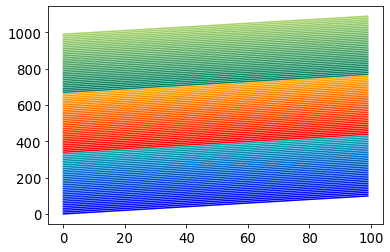

In [23]:
colors = get_colors([34,33,33])
plt.gca().set_prop_cycle(color=colors)
plt.plot([[(i*10)+j for i in range(100)] for j in range(100)])
plt.show()

In [10]:
def circular_unbalance(size, min_val=0.2, max_val=0.8):
    """Returns an influemce graph."""
    inf_graph = np.zeros((size, size))
    step = (max_val - min_val) / size
    for i in range(size):
        inf_graph[i, i] = 1.0
        inf_graph[i, (i+1) % size] =  min_val + step * i
    return inf_graph

def double_circular(num_agents, inner_inf=0.1, outer_inf=0.2):
    """Returns an influemce graph."""
    inf_graph = np.zeros((num_agents, num_agents))
    for i in range(num_agents):
        inf_graph[i, i] = 1.0
        inf_graph[i, (i+1) % num_agents] = inner_inf
        inf_graph[i, (i+2) % num_agents] = outer_inf
    return inf_graph

In [5]:
circulars_unbalance = [{
    "sim": plr.Simulation(plr.build_belief(blf, 9), circular_unbalance(9)),
    "blf": blf,
    "inf": plr.Influence.CIRCULAR,
    "id" : 0 }  for blf in plr.Belief if blf is not plr.Belief.CONSENSUS
]

for i in cli.ProgressRange(len(circulars_unbalance), "running"):
   circulars_unbalance[i]["sim"] = circulars_unbalance[i]["sim"].run(200, False)

Progress: [====================] 4/4 Done      

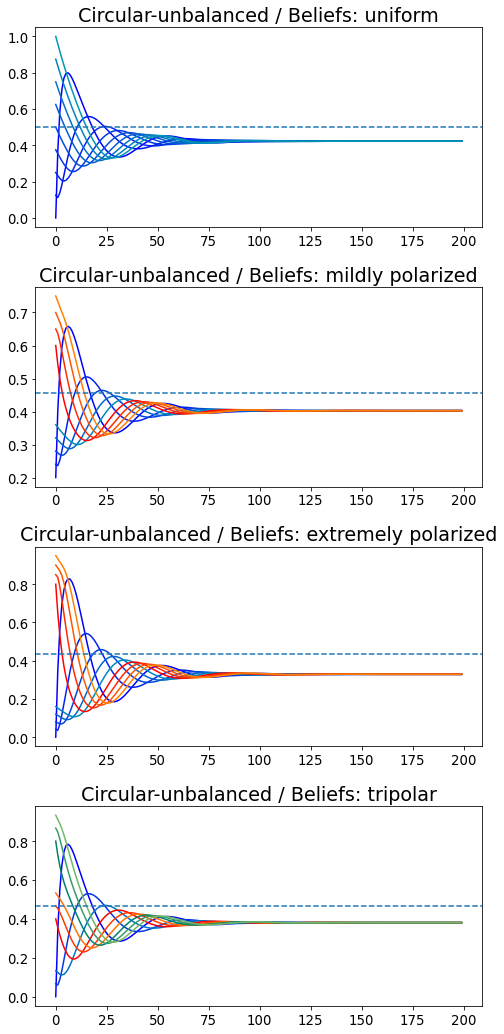

In [24]:
plt.figure(num=1, figsize=(8,18))
plt.subplots_adjust(hspace=0.3)

blfs = [blf for blf in plr.Belief if blf is not plr.Belief.CONSENSUS]

for i, blf in enumerate(blfs):
    plt.subplot(len(blfs), 1, i+1)
    for sim in circulars_unbalance:
        if sim["blf"] == blf:
            plt.gca().set_prop_cycle(color=get_colors(blf, len(sim["sim"][1][0])))
            plt.plot(sim["sim"][1])
            plt.axhline(np.mean(sim["sim"][1][0]), linestyle="dashed")
    plt.title("Circular-unbalanced / Beliefs: {}".format(get_hr_name(blf)))
plt.show()

In [12]:
classic_simulations =  run_simulations(plr.make_update_fn(plr.Update.CLASSIC))

Progress: [====================] 28/28 Done      

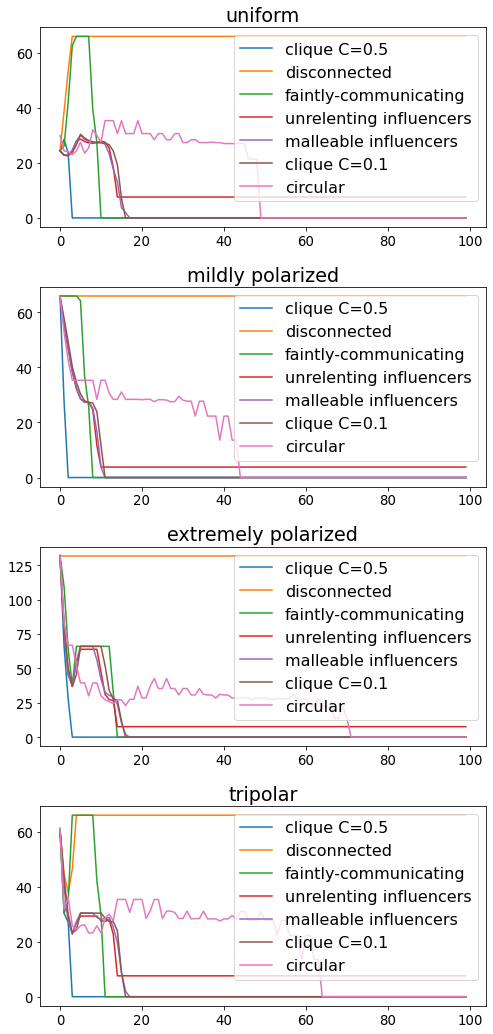

In [25]:
beliefs = [blf for blf in plr.Belief if blf is not plr.Belief.CONSENSUS]
plt.figure(num=1, figsize=(8,18))
plt.subplots_adjust(hspace=0.3)
for i, blf in enumerate(beliefs):
    plt.subplot(len(beliefs), 1, i+1)
    for sim in classic_simulations:
        if sim["blf"] == blf:
            inf_name = get_hr_name(sim["inf"])
            if sim["inf"] is plr.Influence.CLIQUE:
                if sim["id"] == 0:
                    inf_name += " C=0.1"
                else:
                    inf_name += " C=0.5"
            plt.plot(sim["sim"][0][:100], label=inf_name)
    plt.title(get_hr_name(blf))
    plt.legend(loc="upper right")
plt.show()

In [ ]:
# Generates all the plots, but removes the Consensus configuration,
# and replaces the circular simulations to use less agents.

sims_for_printing = [sim for sim in classic_simulations if sim["id"] != 0]
for sim in sims_for_printing:
    add_mean = sim["inf"] is plr.Influence.CLIQUE
    limit_x = sim["inf"] is not plr.Influence.CIRCULAR
    plot_simulation(sim, limit_x=limit_x, add_mean=add_mean)

In [15]:
pairs = [(plr.Influence.GROUP_2_FAINT, plr.Belief.TRIPLE), (plr.Influence.GROUP_2_FAINT, plr.Belief.EXTREME), (plr.Influence.INFLUENCERS_2_BALANCED, plr.Belief.EXTREME)]

rational_graphs = [{
    "sim": plr.Simulation(plr.build_belief(blf), plr.build_influence(inf)).run(),
    "blf": blf,
    "inf": inf } for inf, blf in pairs]

cb_graphs = [{
    "sim": plr.Simulation(plr.build_belief(blf), plr.build_influence(inf), plr.make_update_fn(plr.Update.CONFBIAS)).run(),
    "blf": blf,
    "inf": inf } for inf, blf in pairs]


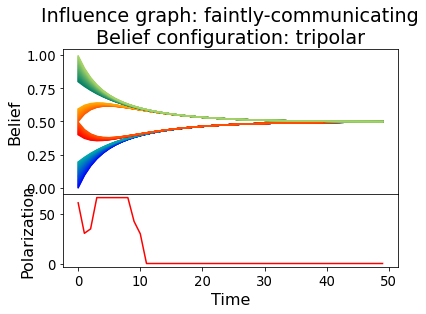

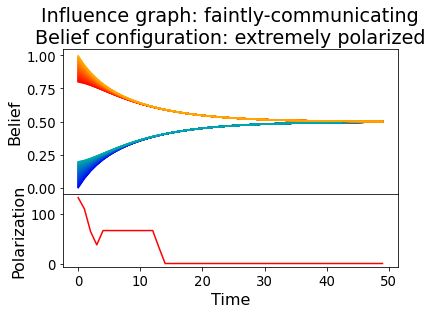

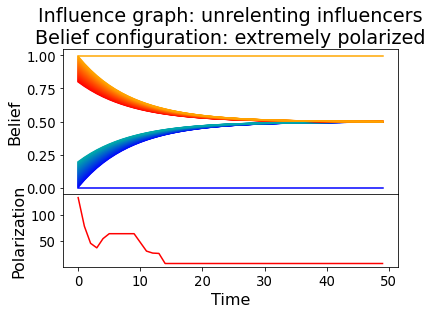

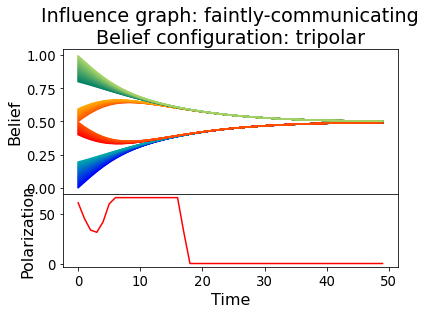

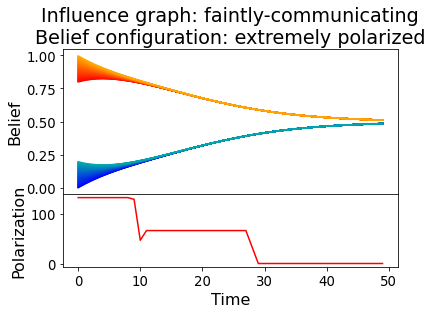

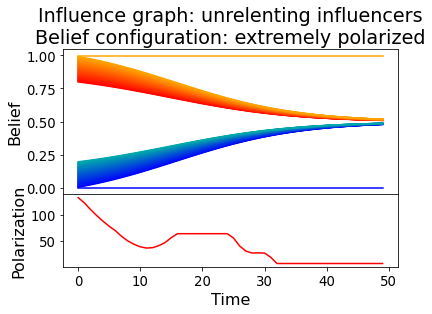

In [26]:
for i, sim in enumerate(itertools.chain(rational_graphs, cb_graphs)):
    if i < 3:
        plot_simulation(sim, limit_x=True, name_prefix="RATIONAL_")
    else:
        plot_simulation(sim, limit_x=True, name_prefix="CB_")

# Other Update Functions

Compare simulations with different Update Functions.

In [17]:
neighbours_simulations = run_simulations(plr.neighbours_update, num_agents=1000)

Progress: [====================] 28/28 Done      

In [18]:
degroot_simulations = run_simulations(plr.degroot_update, cmax_time=500)

Progress: [====================] 28/28 Done      

In [19]:
neighbours_cb_simulations = run_simulations(plr.neighbours_cb_update, num_agents=1000)

Progress: [====================] 28/28 Done      

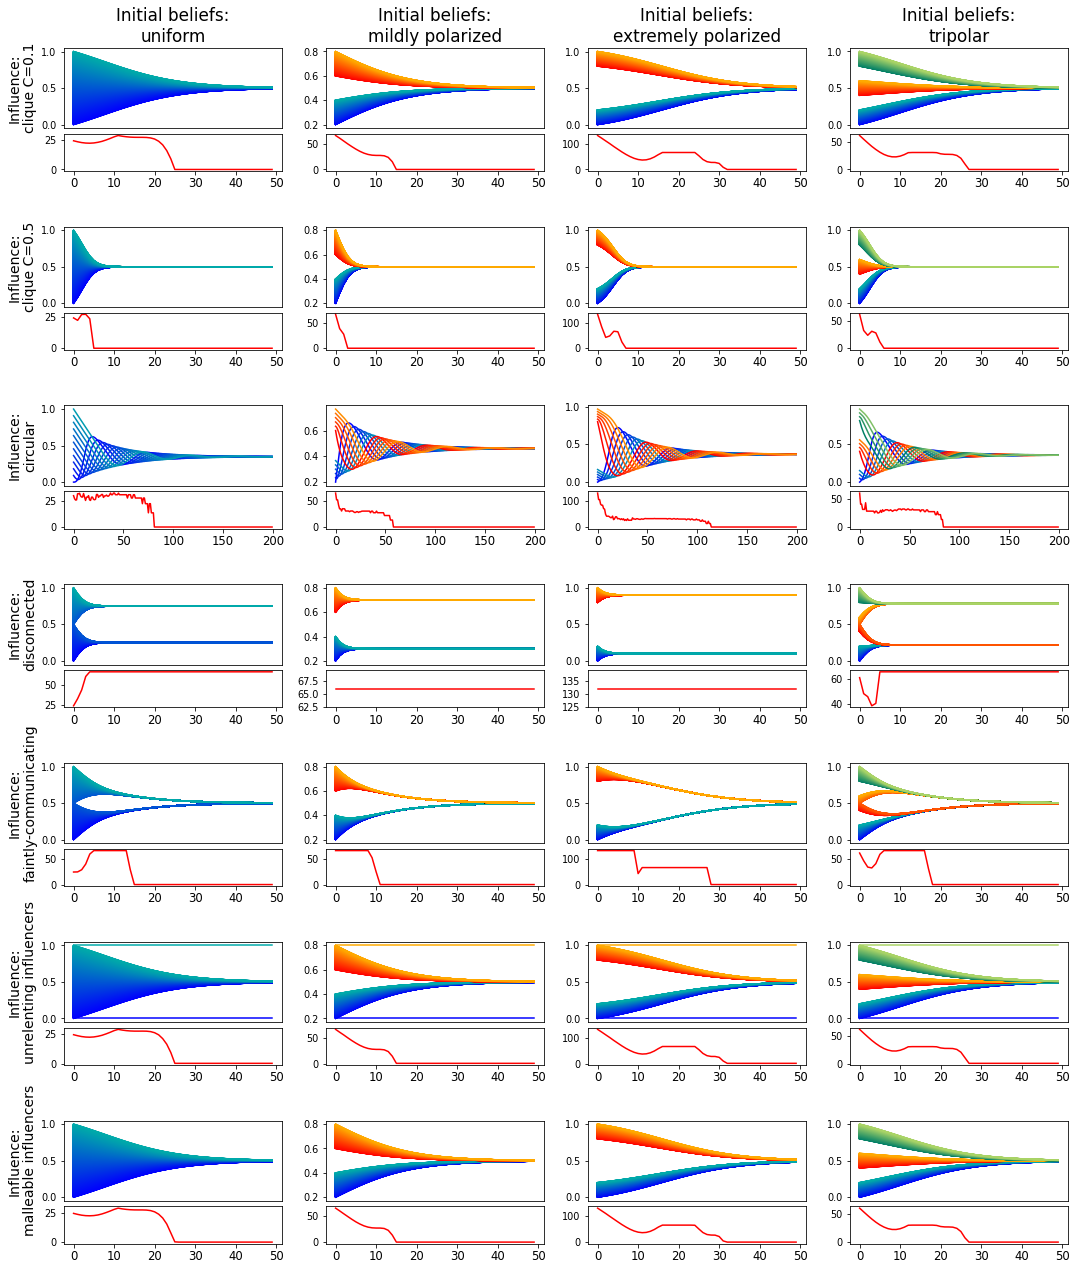

In [40]:
beliefs = [blf for blf in plr.Belief if blf is not plr.Belief.CONSENSUS]
influences = [plr.Influence.CLIQUE, plr.Influence.CLIQUE, plr.Influence.CIRCULAR, plr.Influence.GROUP_2_DISCONECTED, plr.Influence.GROUP_2_FAINT, plr.Influence.INFLUENCERS_2_BALANCED, plr.Influence.INFLUENCERS_2_UNBALANCED]
special_inf_names = ["{} C=0.1".format(get_hr_name(plr.Influence.CLIQUE)), "{} C=0.5".format(get_hr_name(plr.Influence.CLIQUE)), None, None, None, None, None]

# sims = nx_simulations
# sims = neighbours_simulations
sims = neighbours_cb_simulations

with plt.rc_context({'font.size': 14}):
    f = plt.figure(num=1, figsize=(18,22))
    gs = gridspec.GridSpec(len(influences), len(beliefs), figure=f)
    plt.subplots_adjust(hspace=0.45, wspace=0.2)
    for i, inf in enumerate(influences):
        for j, blf in enumerate(beliefs):
            sub_gs = gs[i * len(beliefs) + j].subgridspec(3, 1, hspace=0.15)
            axt = f.add_subplot(sub_gs[:-1, :])
            axb = f.add_subplot(sub_gs[-1, :], sharex=axt)
            axt.get_xaxis().set_visible(False)
            for sim in sims:
                if sim["inf"] == inf and sim["blf"] == blf:
                    if inf is plr.Influence.CLIQUE and sim["id"] != i:
                        continue
                    axt.set_prop_cycle(color=get_colors(blf, len(sim["sim"][1][0])))
                    if inf is plr.Influence.CIRCULAR:
                        axt.plot(sim["sim"][1])
                        axb.plot(sim["sim"][0], color="red")
                        # axb.plot([np.sum(row) for row in sim["sim"][1]], color="red")
                    else:
                        axt.plot(sim["sim"][1][:50])
                        axb.plot(sim["sim"][0][:50], color="red")
                        # axb.plot([np.sum(row) for row in sim["sim"][1][:50]], color="red")
                    inf_name = get_hr_name(inf)
                    if special_inf_names[i] is not None:
                        inf_name = special_inf_names[i]
                    if i == 0:
                        axt.set_title("Initial beliefs:\n{}".format(get_hr_name(blf)))
                    if j == 0:
                        axt.set_ylabel("Influence:\n{}".format(inf_name))
    plt.show()

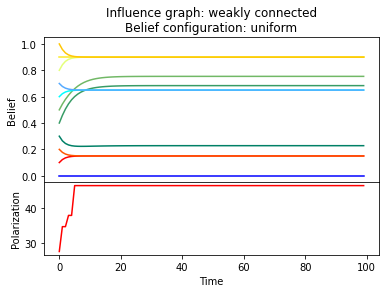

In [14]:
i = 0.5
inf = np.array([
    [0, 0, 0, i, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, i, i, 0, 0, 0, 0, 0, 0, 0],
    [0, i, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, i, 0, 0, 0, 0, 0],
    [0, 0, 0, i, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, i, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, i, 0, 0, i, 0, 0, 0],
    [0, 0, 0, 0, i, 0, i, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, i, i],
    [0, 0, 0, 0, 0, 0, 0, 0, i, 0, i],
    [0, 0, 0, 0, 0, 0, 0, 0, i, i, 0]
])
np.fill_diagonal(inf, 1.0)

pol_history, belief_history, _ = plr.Simulation(plr.build_belief(plr.Belief.UNIFORM, len(inf)), inf, plr.neighbours_cb_update).run()
plot_simulation({"sim": (pol_history, belief_history), "blf": plr.Belief.UNIFORM}, inf_name="weakly connected", file_name="WEAKLY_UNIFORM", color_groups=[1,2,3,2,3])

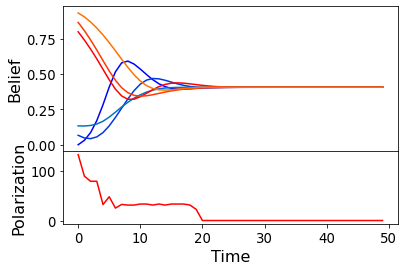

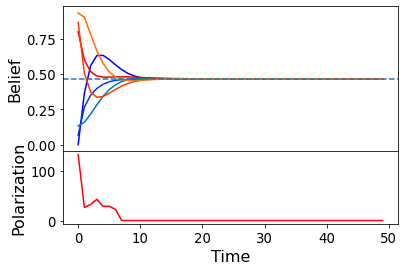

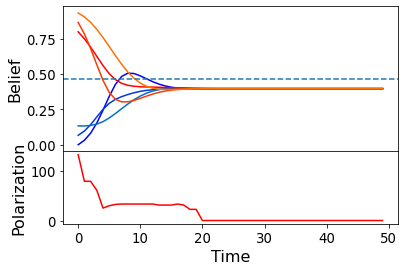

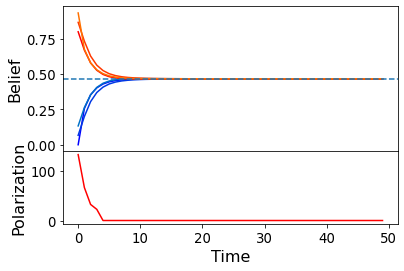

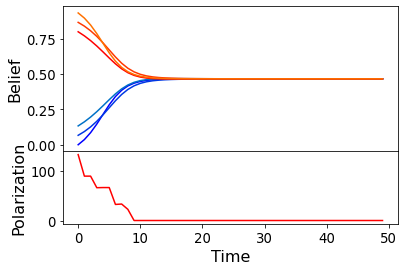

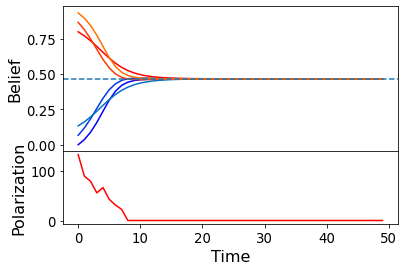

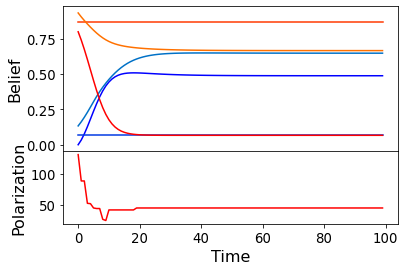

In [31]:
blf_type = plr.Belief.EXTREME
inf_type = plr.Influence.CIRCULAR

# blfs = [0.0, 0.1, 0.7, 0.8, 0.9, 1]
blfs = plr.build_belief(blf_type, 6)
infs = [np.array([ # Initial
    [1.0, 0.6, 0.4, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.6, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0, 0.6, 0.0],
    [0.0, 0.0, 0.2, 1.0, 0.0, 0.4],
    [0.0, 0.0, 0.0, 0.0, 1.0, 0.6],
    [1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
]), np.array([ # Regular
    [1.0, 0.6, 0.4, 0.2, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.6, 0.8, 0.0],
    [0.0, 0.0, 1.0, 0.0, 0.6, 0.0],
    [0.2, 0.0, 0.2, 1.0, 0.0, 0.4],
    [0.0, 0.8, 0.0, 0.0, 1.0, 0.6],
    [1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
]), np.array([ # Symmetric
    [1.0, 0.6, 0.4, 0.0, 0.0, 1.0],
    [0.6, 1.0, 0.0, 0.6, 0.0, 0.0],
    [0.4, 0.0, 1.0, 0.2, 0.6, 0.0],
    [0.0, 0.6, 0.2, 1.0, 0.0, 0.4],
    [0.0, 0.0, 0.6, 0.0, 1.0, 0.6],
    [1.0, 0.0, 0.0, 0.4, 0.6, 1.0]
]), np.array([ # Regular Symmetric
    [1.0, 0.6, 0.4, 0.0, 0.0, 1.0],
    [0.6, 1.0, 0.0, 0.6, 0.8, 0.0],
    [0.4, 0.0, 1.0, 0.2, 0.6, 0.0],
    [0.0, 0.6, 0.2, 1.0, 0.0, 0.4],
    [0.0, 0.8, 0.6, 0.0, 1.0, 0.6],
    [1.0, 0.0, 0.0, 0.4, 0.6, 1.0]
]), np.array([ # Initial but invert 0-1 and 2-4
    [1.0, 0.0, 0.4, 0.0, 0.0, 0.0],
    [0.6, 1.0, 0.0, 0.6, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.2, 1.0, 0.0, 0.4],
    [0.0, 0.0, 0.6, 0.0, 1.0, 0.6],
    [1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
])]
sims_circ = [{
    "sim": plr.Simulation(blfs, infs[0], plr.neighbours_cb_update).run(50),
    "name": "CB_CIRCULATION_EXTREME",
    "blf": blf_type,
    "inf": inf_type,
    "mean": False
}, {
    "sim": plr.Simulation(blfs, infs[1], plr.neighbours_update).run(50),
    "name": "RATIONAL_CIRCULATION_REGULAR_EXTREME",
    "blf": blf_type,
    "inf": inf_type,
    "mean": True
}, {
    "sim": plr.Simulation(blfs, infs[1], plr.neighbours_cb_update).run(50),
    "name": "CB_CIRCULATION_REGULAR_EXTREME",
    "blf": blf_type,
    "inf": inf_type,
    "mean": True
}, {
    "sim": plr.Simulation(blfs, infs[2], plr.neighbours_update).run(50),
    "name": "RATIONAL_CIRCULATION_SYM_EXTREME",
    "blf": blf_type,
    "inf": inf_type,
    "mean": True
}, {
    "sim": plr.Simulation(blfs, infs[2], plr.neighbours_cb_update).run(50),
    "name": "CB_CIRCULATION_SYM_EXTREME",
    "blf": blf_type,
    "inf": inf_type,
    "mean": False
}, {
    "sim": plr.Simulation(blfs, infs[3], plr.neighbours_cb_update).run(50),
    "name": "CB_CIRCULATION_REGULAR_SYM_EXTREME",
    "blf": blf_type,
    "inf": inf_type,
    "mean": True
}, {
    "sim": plr.Simulation(blfs, infs[4], plr.neighbours_cb_update).run(),
    "name": "CB_WEAKLY_EXTREME",
    "blf": blf_type,
    "inf": None,
    "mean": False
}]

for sim_circ in sims_circ:
    plot_simulation(sim_circ, blf_name="", inf_name="", add_mean=sim_circ['mean'], file_name=sim_circ["name"])

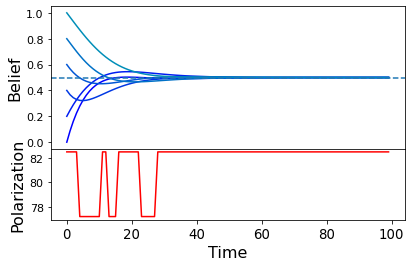

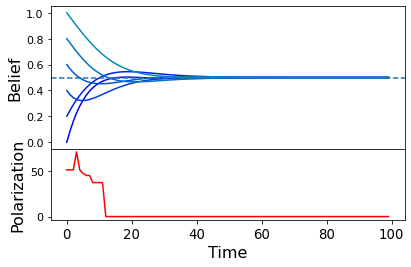

In [39]:
double_sim = [{
    "sim": plr.Simulation(
        plr.build_belief(plr.Belief.UNIFORM, 6),
        double_circular(6, 0.1, 0.2),
        plr.neighbours_update,
        num_bins=2).run(),
    "blf": plr.Belief.UNIFORM,
    "inf": None
}, {
    "sim": plr.Simulation(
        plr.build_belief(plr.Belief.UNIFORM, 6),
        double_circular(6, 0.1, 0.2),
        plr.neighbours_update,
        num_bins=3).run(),
    "blf": plr.Belief.UNIFORM,
    "inf": None
}]

with plt.rc_context({'figure.autolayout': True}):
    plot_simulation(double_sim[0],blf_name="", inf_name="", add_mean=True, file_name="neighbours_double_circular_2_bins")
    plot_simulation(double_sim[1],blf_name="", inf_name="", add_mean=True, file_name="neighbours_double_circular_3_bins")

## Comparisons

Between update functions and initial belief configurations.

In [32]:
# Extend simulations with the update function data
for sim in neighbours_simulations:
    sim["fn"] = plr.Update.CLASSIC
for sim in neighbours_cb_simulations:
    sim["fn"] = plr.Update.CONFBIAS

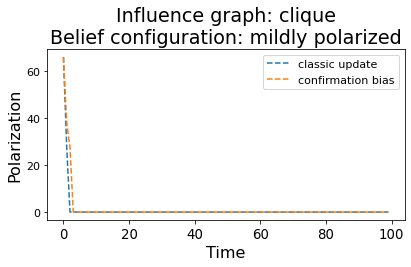

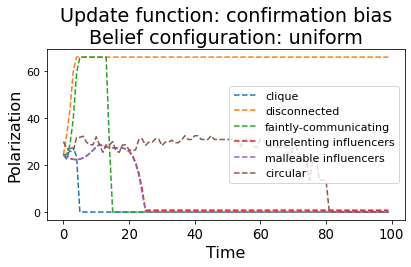

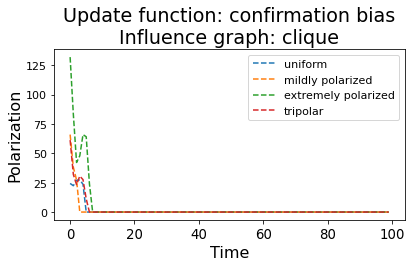

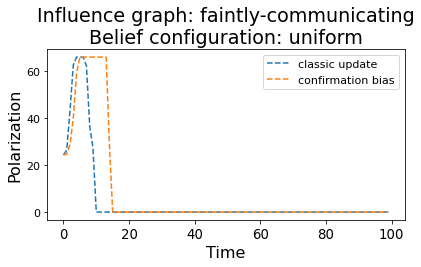

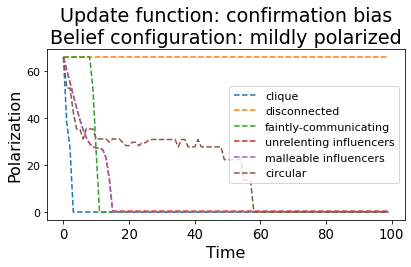

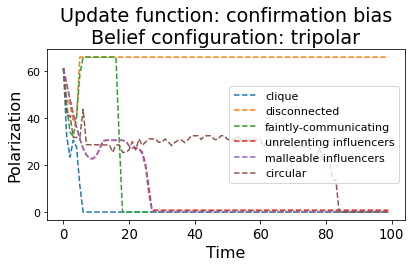

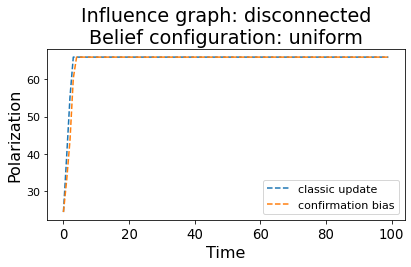

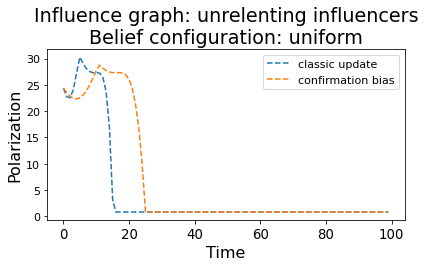

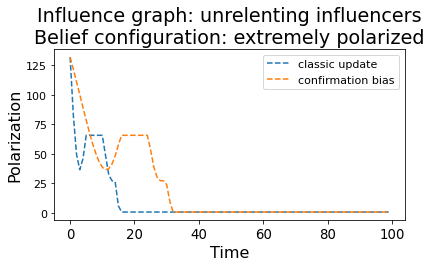

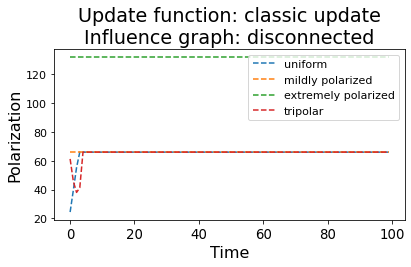

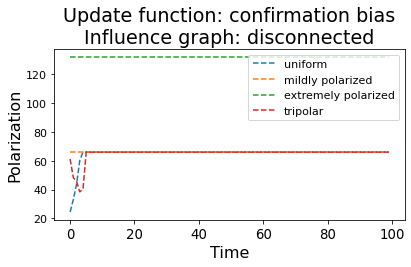

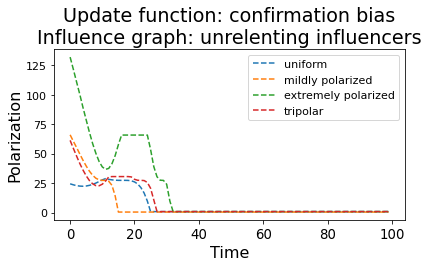

In [38]:
pairs_to_plot = [
    {"var": "fn", "inf": plr.Influence.CLIQUE, "blf": plr.Belief.MILD},
    {"var": "inf", "fn": plr.Update.CONFBIAS, "blf": plr.Belief.UNIFORM},
    {"var": "blf", "fn": plr.Update.CONFBIAS, "inf": plr.Influence.CLIQUE},
    {"var": "fn", "inf": plr.Influence.GROUP_2_FAINT, "blf": plr.Belief.UNIFORM},
    {"var": "inf", "fn": plr.Update.CONFBIAS, "blf": plr.Belief.MILD},
    {"var": "inf", "fn": plr.Update.CONFBIAS, "blf": plr.Belief.TRIPLE},
    {"var": "fn", "inf": plr.Influence.GROUP_2_DISCONECTED, "blf": plr.Belief.UNIFORM},
    {"var": "fn", "inf": plr.Influence.INFLUENCERS_2_BALANCED, "blf": plr.Belief.UNIFORM},
    {"var": "fn", "inf": plr.Influence.INFLUENCERS_2_BALANCED, "blf": plr.Belief.EXTREME},
    {"var": "blf", "fn": plr.Update.CLASSIC, "inf": plr.Influence.GROUP_2_DISCONECTED},
    {"var": "blf", "fn": plr.Update.CONFBIAS, "inf": plr.Influence.GROUP_2_DISCONECTED},
    {"var": "blf", "fn": plr.Update.CONFBIAS, "inf": plr.Influence.INFLUENCERS_2_BALANCED},
]

with plt.rc_context({'figure.autolayout': True}):
    for plot_pair in pairs_to_plot:
        if plot_pair["var"] == "fn":
            # We should obtain only one result.
            to_plot = (pair for pair in zip(neighbours_simulations, neighbours_cb_simulations) 
                if (pair[0]["inf"] == pair[1]["inf"] == plot_pair["inf"]) and (pair[0]["blf"] == pair[1]["blf"] == plot_pair["blf"]))
            plot_only_polarization({"sim": next(to_plot), "inf": plot_pair["inf"], "blf": plot_pair["blf"]}, limit_x=True)
        else:
            if plot_pair["fn"] is plr.Update.CLASSIC:
                source_sim = neighbours_simulations
            else:
                source_sim = neighbours_cb_simulations
            if plot_pair["var"] == "inf":
                to_plot = (sim for sim in source_sim if sim["blf"] == plot_pair["blf"] and sim["id"] == 1)
                plot_only_polarization({"sim": to_plot, "fn": plot_pair["fn"], "blf": plot_pair["blf"]}, limit_x=True)
            elif plot_pair["var"] == "blf":
                to_plot = (sim for sim in source_sim if sim["inf"] == plot_pair["inf"] and sim["id"] == 1)
                plot_only_polarization({"sim": to_plot, "fn": plot_pair["fn"], "inf": plot_pair["inf"]}, limit_x=True)